### Import and global settings

In [23]:
import seaborn as sn
import numpy as np
import pandas as pd
import json
import csv
import calendar
import matplotlib.pyplot as plt

#Kullanılmayan importlar deneyebileceğin şeyler hakkında fikir vermesi için, silme
from sklearn.pipeline import Pipeline
from sklearn.base import BaseEstimator, TransformerMixin
from datetime import datetime, timedelta
from sklearn.feature_extraction.text import CountVectorizer, HashingVectorizer
from sklearn.preprocessing import LabelEncoder, OneHotEncoder, FunctionTransformer
from sklearn.model_selection import train_test_split, KFold
from sklearn.ensemble import (
    RandomForestRegressor,
    GradientBoostingRegressor,
    AdaBoostRegressor,
    ExtraTreesRegressor,
    BaggingRegressor,
    VotingRegressor,
    StackingRegressor,
    HistGradientBoostingRegressor
)
from sklearn.metrics import mean_squared_error
from typing import Dict, List, Tuple, Any
from collections import Counter

pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', 1)



#the time period constant used to calculate the EMA
DAYS_FOR_EMA = 21
#the time period constant used to calculate the RSI
DAYS_FOR_RSI = 14

#constant used to determine the length of each period to get the average of close price
CLOSE_PRICE_MEAN_DAYS = 7

#period length used fo MA volume calculation
MA_VOLUME_DAYS = 14

RANDOM_STATE = 45

TEST_SIZE = 0.1251353

#number of splits for k-cross validation
K = 5

LOSS_FUNCTION = mean_squared_error

### Pull data

In [24]:
'''

 https://www.kaggle.com/datasets/kannan1314/amazon-stock-price-all-time
 Basic CSV file with open, high, low, close, adjusted close price and volume of Amazon stock for each day.

 https://www.kaggle.com/datasets/henryshan/amazon-com-inc-amzn
 The dataset includes the daily Amazon.com, Inc. stock price. (BU KULLANILMAYABİLİR)


 https://www.kaggle.com/datasets/varpit94/amazon-stock-data
 Amazon (AMZN) historic prices (USD), daily data.

https://www.kaggle.com/datasets/beeru999/amazon-stock-prices1997-2021
This CSV file contains historical stock price data for Amazon (AMZN) from May 15, 1997, to April 5, 2023. The dataset includes the following columns:

Date: The date of the trading day.
Open: The opening price of the stock on that day.
High: The highest price the stock reached during the trading day.
Low: The lowest price the stock reached during the trading day.
Close: The closing price of the stock on that day.
Adj Close: The adjusted closing price, which accounts for dividends, stock splits, and other adjustments.
Volume: The number of shares traded during the day.
'''
#df1 = pd.read_csv('data/Amazon.csv')
#df2 = pd.read_csv('data/AMZN.csv')
#df3 = pd.read_csv('data/AMZN (1).csv')
#TODO şimdilik tek dataset, datalar farklı kafa karışmasın
df4 = pd.read_csv('data/AMZN (2).csv')



### display

In [25]:
#display(df1.iloc[-1:])
#display(df2.iloc[-1:])
#display(df3.iloc[-1:])
display(df4)

,Date,Open,High,Low,Close,Adj Close,Volume
0,1997-05-15,0.121875,0.125,0.096354,0.097917,0.097917,1443120000


### Process data

In [26]:
'''
DATALARDA HER GÜN BULUNMUYOR

RSI EMA falan hesaplarken timedelta değil index bakalım (ya da uygunsuz mu olur)
'''

#TODO MACD sonra bak, hesaplayabilmek için 12 günlük ve 26 günlük EMA da gerekiyor
#TODO volatility kısmı bak (yapılmalı mı?)
#TODO günden güne volume kısmında yüzdelik kısmına bak (pzts salı %40'tan %60'a çıkmış vs.) (buna bakılabilir mi?)

#TODO önceki günleri de hesaba kat
#TODO direk close tahmin etmek yerine, yukarı mı gidecek aşağı mı gidecek onlara bak
#TODO close, volume veya diğer fiyatla ilgilli özelliklere log transofrmation yap varience stabilizasyonu için
#TODO scaling yap

#TODO train test bölerken son günler test olsun

def process_data(df4: pd.DataFrame) -> pd.DataFrame:
    '''Processes the given data and returns the processed data
    Args:
        df (pd.DataFrame): dataframe to be processed
    Returns:
        processed df
    '''
    def is_month_start(row: Dict) -> bool:
        """
        Check if the given date is the start of the month.

        Args:
        row (dict): A dictionary containing a 'Date' key with the date string.

        Returns:
        bool: True if the date is the end of the month, False otherwise.
        """
        return row['Date'].split('-')[2] == '01'

    def is_month_end(row: Dict) -> bool:
        """
        Check if the given date is the end of the month.

        Args:
        row (dict): A dictionary containing a 'Date' key with the date string.

        Returns:
        bool: True if the date is the end of the month, False otherwise.
        """
        #diğeri gibi yapmadık, 28-29 Şubat'ı da dahil edebilmek için
        date_str = row['Date']
        date = datetime.strptime(date_str, "%Y-%m-%d")
        last_day = calendar.monthrange(date.year, date.month)[1]
        return date.day == last_day

    df4["month_start"]=df4.apply(is_month_start, axis=1)
    df4["month_end"]=df4.apply(is_month_end, axis=1)

    df4["high_low_diff"] = df4["High"] - df4["Low"]

    df4["open_close_diff"] = df4["Open"] - df4["Close"]

    df4["volume*Close"] = df4["Volume"] * df4["Close"]

    '''DATA HER BİR GÜNÜ İÇERMİYOR, 7 GÜNLÜK ORTALAMA VS. MANTIKLI MI?'''

    #14 gün de olabilir
    def get_close_avg(row: Dict, days: int, df: pd.DataFrame) -> float:
        """
        Get the average of the closing prices of the previous 7 days.

        Args:
        row (dict): A dictionary containing a 'Date' key with the date string.

        Returns:
        float: The average of the closing prices of the previous 7 days.
        """
        #get the previous 7 days
        if row.name < 7:
            return 0
        else:
            index = row.name
            close_avg = df.loc[index-days:index]["Close"].mean()
            return close_avg

    df4[f"close_price_mean_{CLOSE_PRICE_MEAN_DAYS}_days"] = df4.apply(lambda row: get_close_avg(row, CLOSE_PRICE_MEAN_DAYS, df4), axis=1)

    def calculate_ema(row: Dict, ema_period: int, df: pd.DataFrame) -> float:
        """
        Calculate the Exponential Moving Average (EMA) for a given row.

        Args:
        row (dict): A dictionary containing the row data.
        ema_period (int): The number of periods to consider for calculating EMA.

        Returns:
        float: The EMA value for the given row.
        """
        #for initial prices, return the average of close prices over n number of periods (a simple moving average)
        if row.name < ema_period:
            return df4.loc[:row.name, 'Close'].mean()
        #for others, calculate the EMA normally
        else:
            previous_ema = df4.loc[row.name - 1, f'ema_{ema_period}']
            close_price = row['Close']
            smoothing_constant = 2 / (ema_period + 1)
            ema = (close_price - previous_ema) * smoothing_constant + previous_ema
            return ema

    #we initialize with nan values to avoid key error
    df4[f'ema_{DAYS_FOR_EMA}'] = np.nan
    df4[f'ema_{DAYS_FOR_EMA}'] = df4.apply(lambda row: calculate_ema(row, DAYS_FOR_EMA, df4), axis=1)

    #RSI için ilk 21 gün olmuyor, ilk 21 günü atla
    def calculate_RSI(df: pd.DataFrame, row: Dict, rsi_period: int) -> float:
        '''Calculates the RSI for given row and returns it
        Args:
        df: dataframe used (added as parameter, global variables can be buggy thats why)
        row (dict): A dictionary containing the row data.
        rsi_period (int): The number of periods to consider for calculating RSI.
    
        Returns:
        float: The RSI value for the given row. 
        '''
        #get the index of row (we dont have each day thats why we dont use timedelta)
        index = row.name
        
        #TODO sonradan diff kolonunu kaldırmak gerekebillir
    
        #For the days before first rsi day, return 0 (may also be null)
        if row.name < rsi_period:
            return 0
    
    #get previous 21 rows to use apply function
        prev_close = df.iloc[index-rsi_period:index]

        def calculate_difference(row: Dict, df: pd.DataFrame) -> float:
            '''Calculates the difference between close prices.
            Returns zero for the first day
            Args:
            row (dict): a row in dataframe
            df (DataFrame): dataframe

            Returns:
                diff (float): the difference between two rows close prices. Zero if first day
            '''
            #first day
            if row.name == 0:
                return 0
            #-1 to get the previous day
            index = row.name - 1
            diff = row["Close"] - df.loc[index]["Close"]

            return diff

    #don't include the first day for RSI (cant calculate the difference for first day)
        prev_close["diff"] = prev_close.apply(lambda row: calculate_difference(row, df), axis=1)

        #TODO check this calculation
        avg_gains = prev_close[prev_close["diff"] > 0]["diff"].mean()
        avg_losses = prev_close[prev_close["diff"] < 0]["diff"].mean()

        #calculate and return
        rsi = avg_gains / avg_losses
        return rsi

    #initialize with nan values to avoid key error
    df4[f"RSI_{DAYS_FOR_RSI}_days"] = np.nan
    df4[f"RSI_{DAYS_FOR_RSI}_days"] = df4.apply(lambda row: calculate_RSI(df4, row, DAYS_FOR_RSI), axis=1)

    def calculate_liquidity(row: Dict) -> float:
        '''Calculates the liquidity for the given row
        volume / close
        Args:
        row (dict): a row of the dataframe

        Returns:
            the liquidity of the row
        '''
        return row["Volume"] / row["Close"]

    df4["liquidity"] = df4.apply(calculate_liquidity, axis=1)

    def calculate_MA_volume(row: Dict, days: int, df: pd.DataFrame) -> float:
        '''Calculates the volume moving average over a given period of time
        Args:
        row (dict): a row of dataframe
        days (int): the length of a period
        df (DataFrame): dataframe to operate on
        '''

        if row.name < days:
            return 0
        else:
            index = row.name
            avg = df.loc[index-days: index]["Volume"].mean()
            return avg

    df4[f"volume_MA_{MA_VOLUME_DAYS}_days"] = df4.apply(lambda row: calculate_MA_volume(row, MA_VOLUME_DAYS, df4), axis=1)

    #TODO Nan değerleri kaldır: hata fırlatan regressorların da değerlerini görebilmek içni
    df4.dropna(axis=0, how="any", inplace=True)
    return df4
#pipeline transformation function için gerekli (mi?)



### Model choose and fit

In [27]:
'''
parameter search de bak

scheduler kullan

linear regression

from r_model import Ridge

CNN

dropout

dense

mse kullanıldı genelde

birden fazla model

TRACK transformer model

loss plateau

her okuduğunda datada perturbation yap

pytoerch yoerine tensorflow kullanmak daha etkili olabilir

hipotez testi

Man-Whittney U test

VBO

greed search

gridf

randomizedCV search

torch.inference_mode

LSTM modülü

GRU modülü

tensor çevir

denormalize data

fakrlı grafikler çizdir

seed model
'''

feature_list = df4.columns.tolist()
feature_list.remove("Close")
feature_list.remove("Date")

X = df4[feature_list].to_numpy()
y = np.stack(df4["Close"]) #TODO burayı mı değiştireceğiz (yukarı aşağı kolonu)

x_train, x_test, y_train, y_test = train_test_split(X, y, test_size=TEST_SIZE, random_state=RANDOM_STATE)

kf = KFold(n_splits=K)


# Creating models for each classifier
def define_pipelines() -> List[Pipeline]:
    '''Defines the classifier models, creates pipelines
    and returns them in a list
    Args:
        None
    Returns:
    models (list): a list of pipelines
    '''
    rf_regressor = RandomForestRegressor()
    gb_regressor = GradientBoostingRegressor()
    ab_regressor = AdaBoostRegressor()
    et_regressor = ExtraTreesRegressor()
    bagging_regressor = BaggingRegressor()
    hist_gb_regressor = HistGradientBoostingRegressor()
    #to use for estimators in voting and stacking. 
    sub_list = [
        ('rf', rf_regressor),
        ('gb', gb_regressor),
        ('ab', ab_regressor),
        ('et', et_regressor),
        ('bagging', bagging_regressor),
        #hist_gb_regressor
    ]
    voting_regressor = VotingRegressor(estimators=sub_list)
    stacking_regressor = StackingRegressor(estimators=sub_list)

    models = [
        rf_regressor,
        gb_regressor,
        ab_regressor,
        et_regressor,
        bagging_regressor,
        voting_regressor,
        stacking_regressor,
        hist_gb_regressor
    ]
    pipelines: List[Pipeline] = []
    #list of pipelines
    for m in models:
        pipeline = Pipeline([
            ('process_data', "passthrough"),
            ("model", m)
        ])
        pipelines.append(pipeline)

    return pipelines

pipelines: List[Pipeline] = define_pipelines()

def train_pipelines(pipelines: List[Pipeline], x_train: np.ndarray, kf: KFold, y_train: np.ndarray, loss_function) -> list:
    '''Trains the given pipelines inside the list with k-cross validation and prints their loss scores.
    Returns the trained pipelines.
    Args:
        pipelines (List[Pipeline]): a list of pipelines to be trained
        x_train (np.ndarray): the training set to train the pipelines with
        kf (KFold): object used to split the database for k-cross validation
        y_train (np.ndarray): correct values for x_train
        loss_function (function): metric to measure the performance of the pipelines
    Returns:
        pipelines (List[Pipeline]): a list with trained pipelines
    '''
    for p in pipelines:
        #fold printlemek için kolaylık
        i = 1
        #print yaparken kullanmak için
        model_name = p.named_steps["model"]
        total_score: int = 0
        for train_index, val_index in kf.split(x_train):

            train_set = x_train[train_index]
            val_set = x_train[val_index]

            train_set_labels = y_train[train_index]
            val_set_labels = y_train[val_index]
            try:
                p.fit(train_set, train_set_labels)
            except ValueError as e:
                print(f"{model_name} encountered error '{e}'")
                
            y_pred = p.predict(val_set)
            score = loss_function(val_set_labels, y_pred)
            total_score  += score
            #TODO FARKLI METRİKLER DENE
            print(f"{loss_function.__name__} of training for {model_name} for fold {i}: {score}")
            i += 1
        print(f"Avg {loss_function.__name__} for {kf.get_n_splits()} folds: {total_score/kf.get_n_splits()}")
    return pipelines
pipelines = train_pipelines(pipelines, x_train, kf, y_train, LOSS_FUNCTION)


mean_squared_error of training for RandomForestRegressor() for fold 1: 0.01775029234471087
mean_squared_error of training for RandomForestRegressor() for fold 2: 0.016855355666373317
mean_squared_error of training for RandomForestRegressor() for fold 3: 0.01293295261584316
mean_squared_error of training for RandomForestRegressor() for fold 4: 0.006735663427423
mean_squared_error of training for RandomForestRegressor() for fold 5: 0.02238418548159228
Avg mean_squared_error for 5 folds: 0.015331689907188525
mean_squared_error of training for GradientBoostingRegressor() for fold 1: 0.07407805178656479
mean_squared_error of training for GradientBoostingRegressor() for fold 2: 0.063440814281229
mean_squared_error of training for GradientBoostingRegressor() for fold 3: 0.05879417613517355
mean_squared_error of training for GradientBoostingRegressor() for fold 4: 0.05838474290178933
mean_squared_error of training for GradientBoostingRegressor() for fold 5: 0.07895875889787905
Avg mean_squared

### Test

In [28]:
def test_pipelines(pipelines: List[Pipeline], loss_function) -> Dict[str, float]:
    '''Tests all the pipelines in the given list and returns a dict
    with keys as model names and loss values as values of dict.
    Args:
        pipelines (List[Pipeline]): a list of pipelines to be tested
        loss_function (function): loss function to be used as performance metric
    Returns:
        Dict[str, float]: a dictionary with model names as keys and metric scores as values
    '''
    results: Dict[str, float] = dict()
    for p in pipelines:
        model_name = p.named_steps["model"].__class__.__name__
        try:
            y_pred = p.predict(x_test)
        except ValueError as e:
            print(f"{model_name} encountered error '{e}'")
            break
        score = loss_function(y_test, y_pred)
        #TODO float'a çevirmek gerekebilir
        results[model_name] = score
    return results

histogram_data: Dict[str, float] = test_pipelines(pipelines, LOSS_FUNCTION)
print(histogram_data)
# histogram yapabilmek için liste olarak ihtiyacımız var verilere
model_names = list(histogram_data.keys())
#FIXME buradakilerin np.float(0.235345) değil dümdüz float olması lazım
test_scores = list(histogram_data.values())

{'RandomForestRegressor': np.float64(0.015963570958296404), 'GradientBoostingRegressor': np.float64(0.06937834116581668), 'AdaBoostRegressor': np.float64(6.1399582928730885), 'ExtraTreesRegressor': np.float64(0.014261783009473188), 'BaggingRegressor': np.float64(0.017082593453823104), 'VotingRegressor': np.float64(0.2826907288799143), 'StackingRegressor': np.float64(0.013199328549211534), 'HistGradientBoostingRegressor': np.float64(0.372707347489889)}


### Print results

results
[np.float64(0.015963570958296404), np.float64(0.06937834116581668), np.float64(6.1399582928730885), np.float64(0.014261783009473188), np.float64(0.017082593453823104), np.float64(0.2826907288799143), np.float64(0.013199328549211534), np.float64(0.372707347489889)]


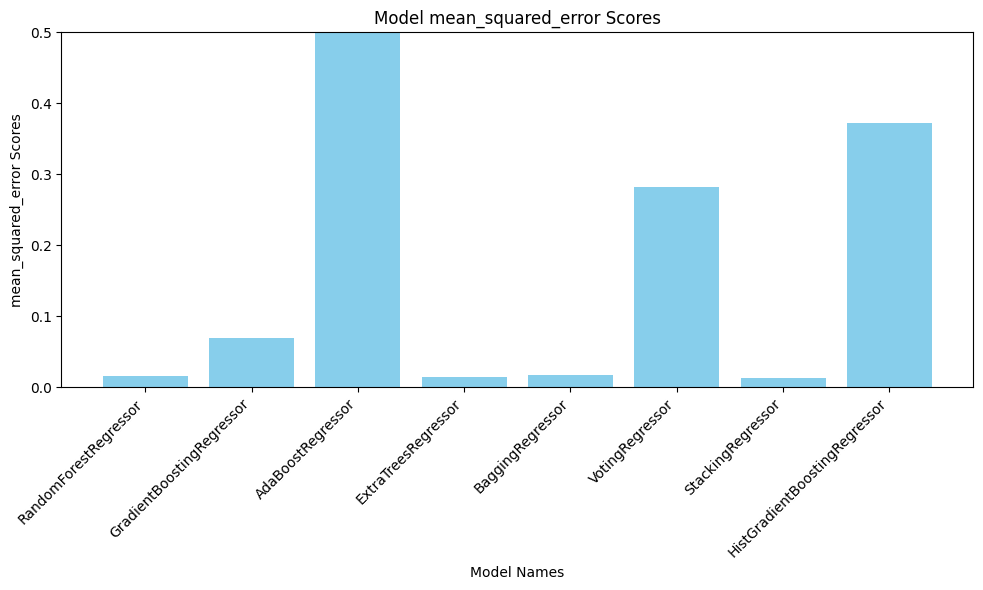

In [34]:
def print_results(model_names: List[str], scores: List[np.float64], loss_function_name: str, scale_value: float) -> None:
    '''Creates a histogram with model names as x axis and loss function scores as y axis
    and displays it.
    Args:
        model_names (List[str]): list of model names to be used for x axis 
        scores (List[np.float64]): list of loss function scores to be used for y axis
        loss_function_name (str): name of loss function to be displayed with f string in Python.
        scale_value (float): value to scale the y axis for better visualization
    Returns:
        None
    '''
    print("results")
    print(scores)
    # Plotting the histogram
    plt.figure(figsize=(10, 6))
    #mse scorelar büyük çoğunluğu 0-1 arasında. Farkı görebilmek için 0-1 arasında sınırladık
    plt.ylim(0, scale_value)
    plt.bar(model_names, scores, color='skyblue')
    plt.xlabel('Model Names')
    plt.ylabel(f'{loss_function_name} Scores')
    plt.title(f'Model {loss_function_name} Scores')
    plt.xticks(rotation=45, ha='right')
    plt.tight_layout()
    plt.show()
#grafik ölçeği ayarlamak için. Küçük farkları görebilmek için küçük değer olması önemli
scale_value = 0.5
print_results(model_names, test_scores, LOSS_FUNCTION.__name__, scale_value)